# Project description
## The gym chain Model Fitness

The gym chain Model Fitness is developing a customer interaction strategy based on analytical data.

One of the most common problems gyms and other services face is customer churn. How do you know if a customer is no longer with you? You can calculate churn based on people who get rid of their accounts or don't renew their contracts.
However, sometimes it's not obvious that a client has left: they may walk out on tiptoes.

Churn indicators vary from field to field. If a user buys from an online store rarely but regularly, you can't say they're a runaway. But if for two weeks they haven't opened a channel that's updated daily, that's a reason to worry: your follower might have gotten bored and left you.

For a gym, it makes sense to say a customer has left if they don't come for a month. Of course, it's possible they're in Cancun and will resume their visits when they return, but's that's not a typical case. Usually, if a customer joins, comes a few times, then disappears, they're unlikely to come back.

In order to fight churn, Model Fitness has digitized a number of its customer profiles. Your task is to analyze them and come up with a customer retention strategy.

***You should:***
- Learn to predict the probability of churn (for the upcoming month) for each customer
- Draw up typical user portraits: select the most outstanding groups and describe their main features
- Analyze the factors that impact churn most
- Draw basic conclusions and develop recommendations on how to improve customer service:
 - Identify target groups
 - Suggest measures to cut churn
 - Describe any other patterns you see with respect to interaction with customers

# Data description

- ```'Churn'``` — the fact of churn for the month in question
- Current dataset fields:
 - User data for the preceding month
   - ```'gender'```
   - ```'Near_Location'``` — whether the user lives or works in the neighborhood where the gym is located
   - ```'Partner'``` — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
   - ```Promo_friends``` — whether the user originally signed up through a "bring a friend" offer (they used a    -       - friend's promo code when paying for their first membership)
   - ```'Phone'``` — whether the user provided their phone number
   - ```'Age'```
   - ```'Lifetime'``` — the time (in months) since the customer first came to the gym


- Data from the log of visits and purchases and data on current membership status
 - ```'Contract_period'``` — 1 month, 3 months, 6 months, or 1 year
 - ```'Month_to_end_contract'``` — the months remaining until the contract expires
 - ```'Group_visits'``` — whether the user takes part in group sessions
 - ```'Avg_class_frequency_total'``` — average frequency of visits per week over the customer's lifetime
 - ```'Avg_class_frequency_current_month'``` — average frequency of visits per week over the preceding month
 - ```'Avg_additional_charges_total'``` — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

# Step 1. Download the data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import math as mth
from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/gym_churn_us.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
data.duplicated().sum()

0

# Step 2. Carry out exploratory data analysis (EDA)

***Look at the dataset: does it contain any missing features? Study the mean values and standard deviation (use the describe() method).***

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [7]:
display(data.isna().sum()*100/len(data))
display(pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm'))
data.isna().mean() * 100 

gender                               0.0
Near_Location                        0.0
Partner                              0.0
Promo_friends                        0.0
Phone                                0.0
Contract_period                      0.0
Group_visits                         0.0
Age                                  0.0
Avg_additional_charges_total         0.0
Month_to_end_contract                0.0
Lifetime                             0.0
Avg_class_frequency_total            0.0
Avg_class_frequency_current_month    0.0
Churn                                0.0
dtype: float64

,0
gender,0.000000
Near_Location,0.000000
Partner,0.000000
Promo_friends,0.000000
Phone,0.000000
Contract_period,0.000000
Group_visits,0.000000
Age,0.000000
Avg_additional_charges_total,0.000000
Month_to_end_contract,0.000000


gender                               0.0
Near_Location                        0.0
Partner                              0.0
Promo_friends                        0.0
Phone                                0.0
Contract_period                      0.0
Group_visits                         0.0
Age                                  0.0
Avg_additional_charges_total         0.0
Month_to_end_contract                0.0
Lifetime                             0.0
Avg_class_frequency_total            0.0
Avg_class_frequency_current_month    0.0
Churn                                0.0
dtype: float64

### Conclusion
- There are no missing values.
- No duplicates were found in the data.
- Approximately the same number of men and women go to the gym.
- 84% of user lives or works in the neighborhood where the gym is located.
- 48% of user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers).
- 30% of user signed up through a "bring a friend" offer.
- 90% of user provided their phone number.
- The average duration of users contract period is 4.6 months.
- 41% user takes part in group sessions.
- Minimum age of users 18 years old, maximum 41 years old, average age 29 years old.
- On average, users spend 147 dollars - it is the total amount of money spent on other gym services: cafes, sporting goods, cosmetics, massages, etc.
- Average term until the end of the contract - 4.3 months.
- Average time (in months) since the client first visited the gym - 3.7 months.
- Average frequency of visits per week over the customer's lifetime - 1,87.
- Average frequency of visits per week over the preceding month - 1,76.
- 26,5% churn for the month in question.



***Look at the mean feature values in two groups: for those who left (churn) and for those who stayed (use the groupby() method).***

In [8]:
(round(data["Churn"].value_counts()/data.shape[0],2)).to_frame("Churn Proportions")

,Churn Proportions
0,0.73
1,0.27


In [9]:
churn_groups =data.groupby("Churn").mean().T
churn_groups

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


### Conclusion
**0 - means that users stay (73%)**<br>
**1 - users leave (27%)**
- The same number of men and women go to the gym.
- Users who live or work closer are less likely to churn, which is quite logical.
- Employees of partner companies are less likely to stop visiting a fitness gym than other users.
- Users who signed up under the “bring a friend” offer are less likely to leave.
- The presence of a client's mobile number does not differ in groups.
- The average duration of the contract is longer for regular customers, and for those who have stopped going to the gym, the contract period is 1 month (rather, this indicates that more often customers conclude a contract for 1 month).
- Those who stayed go to group classes more.
- The groups have a difference in the average age of clients, in the churn the average age is 26 years, less than 3 years than in those who continue to go to the gym.
- There is a difference in income between groups, but it is not critical.
- The remaining time before the expiration of the contract is logically longer for the remaining customers.
- Users in churn have lower average number of visits per week for all time.
- The number of visits in the previous month is two times lower for users in the churn.

***Plot bar histograms and feature distributions for those who left (churn) and those who stayed.***

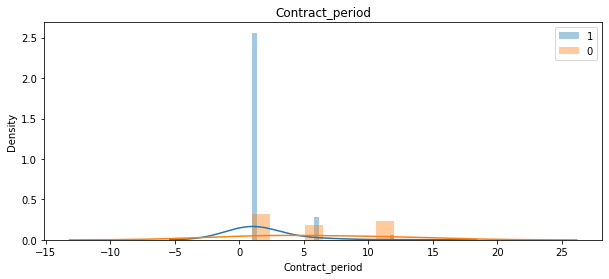

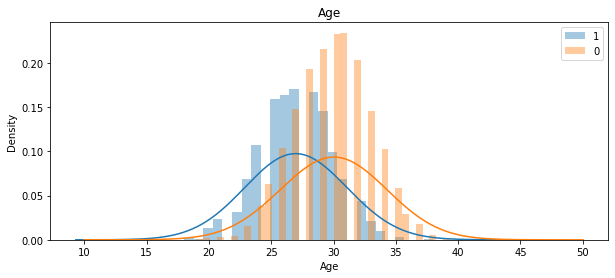

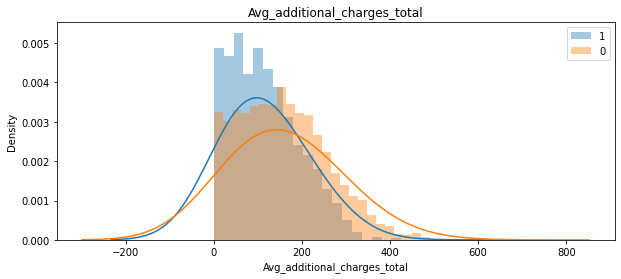

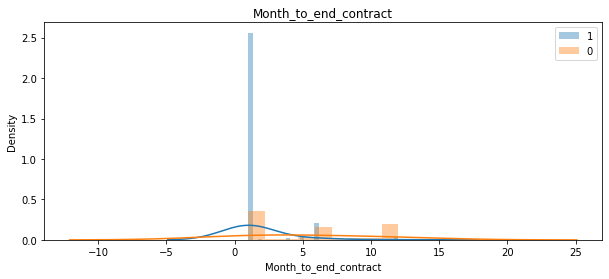

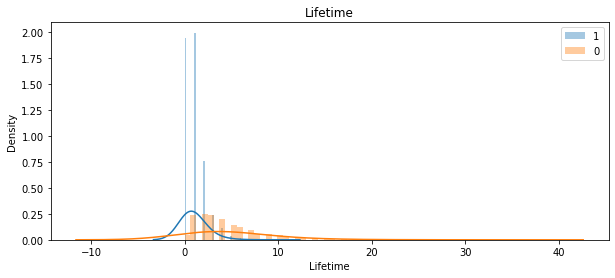

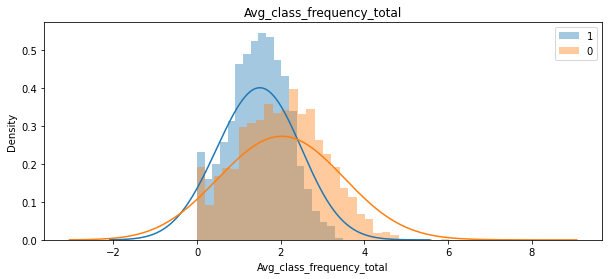

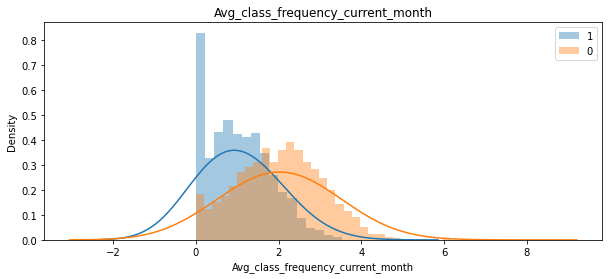

In [10]:
churn_1 = data.loc[data['Churn'] == 1]
churn_0 = data.loc[data['Churn'] == 0]
numeric_columns = ['Contract_period', 'Age','Avg_additional_charges_total', 'Month_to_end_contract',
                   'Lifetime','Avg_class_frequency_total', 'Avg_class_frequency_current_month']

for column in numeric_columns:
    plt.figure(figsize = (10,4))
    plt.title(column)
    sns.distplot(churn_1[column], kde_kws = {'bw': 1}, label='1')
    sns.distplot(churn_0[column], kde_kws = {'bw': 1}, label='0')
    plt.legend()
    plt.show()


In [11]:
data.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn'],
      dtype='object')

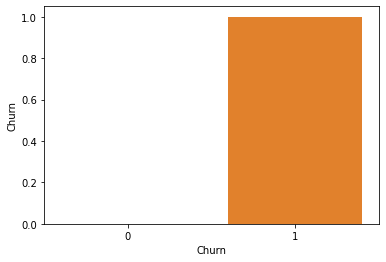

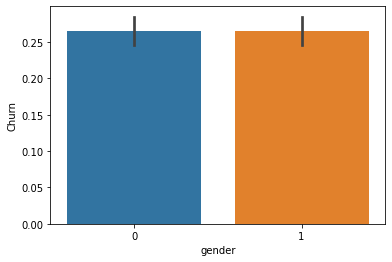

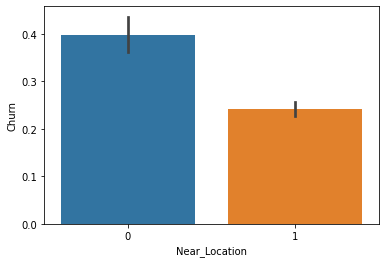

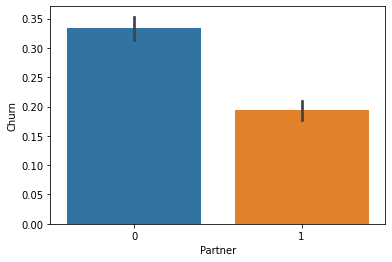

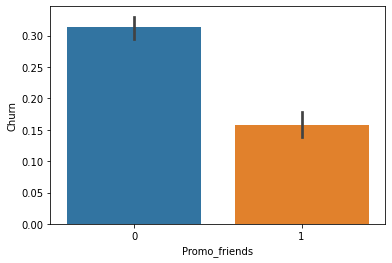

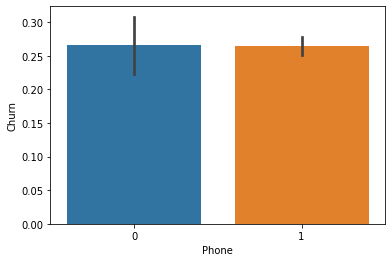

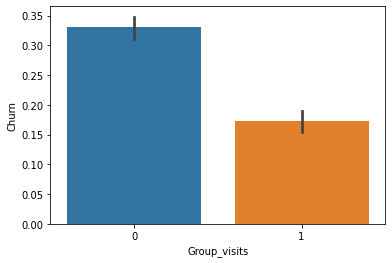

In [12]:
boolean_columns = ['Churn', 'gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']

for boolean_column in boolean_columns:
    plt.figure()
    sns.barplot(data = data, x = boolean_column, y = 'Churn')


***Build a correlation matrix and display it.***

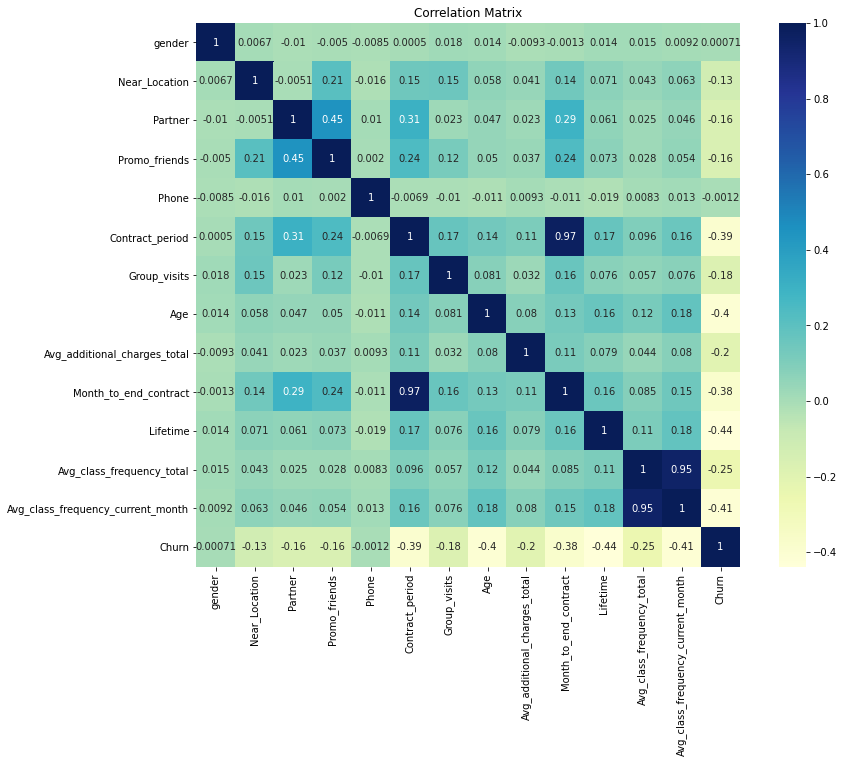

In [13]:
plt.figure(figsize=(14,10))
sns.heatmap(data = data.corr(), annot=True, square=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

It can be seen from the analysis of the map that the parameters Contract_period (the duration of the subscription activity) and Month_to_end_contract (the months remaining until the contract expires) are very strongly correlated (97%).

The parameters Avg_class_frequency_total (average frequency of visits per week over the customer's lifetime) and Avg_class_frequency_current_month (average frequency of visits per week over the preceding month) also strongly correlate.

Therefore, one column needs to be removed from a pair of highly correlated data.


In [14]:
data_filtered = data.drop('Month_to_end_contract', axis=1) 
data_filtered = data_filtered.drop('Avg_class_frequency_current_month', axis=1) 
data_filtered.head()


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0


# Step 3. Build a model to predict user churn

***Build a binary classification model for customers where the target feature is the user's leaving next month.***
- ***Divide the data into train and validation sets using the train_test_split() function.***

In [15]:
# divide the data into features (the X matrix) and a target variable (y)
X = data_filtered.drop(columns = ['Churn'])
y = data_filtered['Churn']

# divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

# create a StandardScaler object and apply it to the train set
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)   # train the scaler and transform the matrix for the train set

# apply standardization to the feature matrix for the test set
X_test_st = scaler.transform(X_test)

***Train the model on the train set with two methods:***
- ***logistic regression***
- ***random forest***

In [16]:
#logistic regression
logistic_model = LogisticRegression(random_state = 0)
logistic_model.fit(X_train_st, y_train)
y_pred = logistic_model.predict(X_test_st)

print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print()
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print()
print('Recall: {}'.format(recall_score(y_test, y_pred)))

Accuracy: 0.89875

Precision: 0.7881773399014779

Recall: 0.8080808080808081


In [17]:
#random forest
forest_model = RandomForestClassifier(random_state = 0)
forest_model.fit(X_train_st, y_train)
y_pred2 = forest_model.predict(X_test_st)
 
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred2)))
print()
print('Precision: {}'.format(precision_score(y_test, y_pred2)))
print()
print('Recall: {}'.format(recall_score(y_test, y_pred2)))

Accuracy: 0.89

Precision: 0.7864583333333334

Recall: 0.7626262626262627


***Evaluate accuracy, precision, and recall for both models using the validation data. Use them to compare the models. Which model gave better results?***

### Conclusion
Both models show a good result, but in the comparison of parameters it is clear that the logistic regression model is better on all points, so I would advise using it.


# Step 4. Create user clusters

***Set aside the column with data on churn and identify object (user) clusters:***
 - ***Standardize the data.***

In [18]:
sc = StandardScaler()
X_st = sc.fit_transform(X)

***Use the linkage() function to build a matrix of distances based on the standardized feature matrix and plot a dendrogram. Note: rendering the dendrogram may take time! Use the resulting graph to estimate the number of clusters you can single out.***

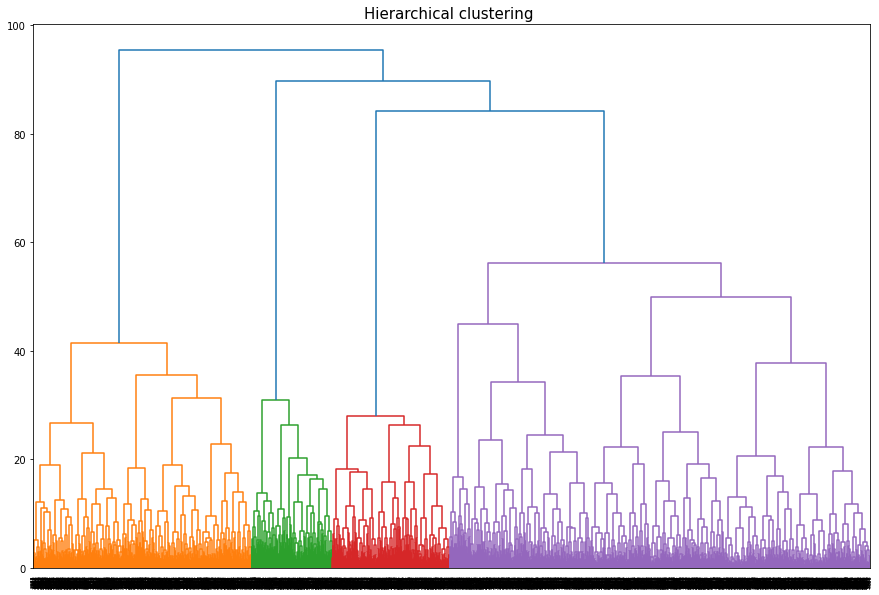

In [19]:
linked = linkage(X_st, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering ', fontsize=15)
plt.show()

***It can be seen from the dendrogram that the algorithm proposes to divide all data into 4 clusters (highlighted in different colors on the dendrogram).***



***Train the clustering model with the K-means algorithm and predict customer clusters. (Let the number of clusters be n=5, so that it'll be easier to compare your results with those of other students. However, in real life, no one will give you such hints, so you'll have to decide based on the graph from the previous step.)***

In [20]:
km = KMeans(n_clusters = 5, random_state = 0)  # define the k_means model with 5 clusters
labels = km.fit_predict(X_st)



In [21]:
# store cluster labels in the field of our dataset
data_filtered['cluster'] = labels

***Look at the mean feature values for clusters. Does anything catch your eye?***

In [22]:
data_filtered.groupby(['cluster']).mean().T

cluster,0,1,2,3,4
gender,0.499109,0.488571,0.505300,0.544202,0.523316
Near_Location,0.000000,0.995238,1.000000,1.000000,0.862694
Partner,0.488414,0.955238,0.238516,0.250287,0.471503
Promo_friends,0.076649,0.892381,0.059187,0.079219,0.305699
Phone,1.000000,1.000000,1.000000,1.000000,0.000000
Contract_period,3.032086,7.660952,2.819788,4.528129,4.777202
Group_visits,0.235294,0.458095,0.000000,1.000000,0.427461
Age,28.721925,29.543810,28.770318,29.536165,29.297927
Avg_additional_charges_total,137.540009,155.861428,143.383993,148.088897,144.208179
Lifetime,3.060606,4.380952,3.343640,3.761194,3.940415


### Conclusion
- Cluster zero has an average near_location value of 0, while clusters 2 and 3 have an average value of 1.
- The first cluster has a high percentage of people who came from partners - 95%.
- No one provided a phone number for the fourth cluster.
- The second cluster has zero attendance of group classes, and the third one has 100% attendance.
- The first cluster has the lowest churn rate.

***Plot distributions of features for the clusters. Do you notice anything?***

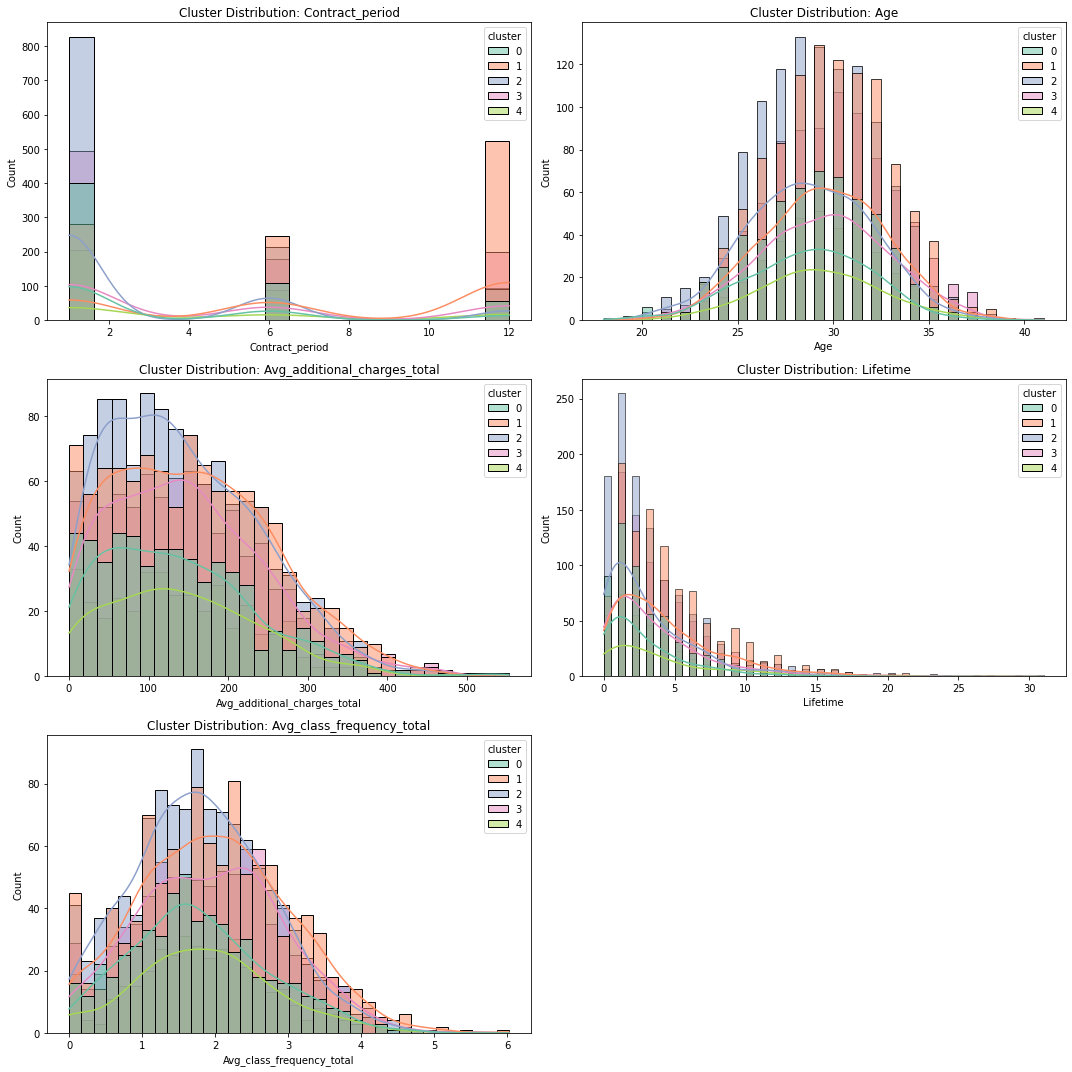

In [23]:
count=1
data_cluster = data_filtered[['Contract_period', 'Age','Avg_additional_charges_total', 'Lifetime','Avg_class_frequency_total', 'Churn','cluster']]
plt.subplots(figsize=(15, 15))

for i in data_cluster.drop(["Churn", "cluster"],axis=1).columns:
    if count > 10:
        continue
    else:
        plt.subplot(3,2,count)
        sns.histplot(data = data_cluster, x= i, hue="cluster", kde=True,  palette="Set2")
        plt.title('Cluster Distribution: {}'.format(str(i)))
        count+=1

plt.tight_layout()
plt.show()


***Calculate the churn rate for each cluster (use the groupby() method). Do they differ in terms of churn rate? Which clusters are prone to leaving, and which are loyal?***

In [24]:
data_filtered.groupby(['cluster'])['Churn'].mean()

cluster
0    0.399287
1    0.120952
2    0.381625
3    0.200918
4    0.266839
Name: Churn, dtype: float64

**The least churn in 1 cluster is 12%, the most churn in zero cluster is almost 40%.**


# Step 5. Come up with conclusions and basic recommendations on working with customers

***Step 1-2:*** <br>
At the beginning of the analysis, the average values of two categories of clients were considered - those who left the fitness center and those who remained its client, as well as graphs and a heat map of correlations.

***Conclusions on the available data:***
- Approximately the same number of men and women go to the gym.
- 84% of user lives or works in the neighborhood where the gym is located.
- 48% of user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers).
- 30% of user signed up through a "bring a friend" offer.
- 90% of user provided their phone number.
- The average duration of users contract period is 4.6 months.
- 41% user takes part in group sessions.
- Minimum age of users 18 years old, maximum 41 years old, average age 29 years old.
- On average, users spend 147 dollars - it is the total amount of money spent on other gym services: cafes, sporting goods, cosmetics, massages, etc.
- Average term until the end of the contract - 4.3 months.
- Average time (in months) since the client first visited the gym - 3.7 months.
- Average frequency of visits per week over the customer's lifetime - 1,87.
- Average frequency of visits per week over the preceding month - 1,76.
- 26,5% churn for the month in question.

***Conclusions based on the differences in characteristics between users who fell into the churn and those who remained:***
- The same number of men and women go to the gym.
- Users who live or work closer are less likely to churn, which is quite logical.
- Employees of partner companies are less likely to stop visiting a fitness gym than other users.
- Users who signed up under the “bring a friend” offer are less likely to leave.
- The presence of a client's mobile number does not differ in groups.
- The average duration of the contract is longer for regular customers, and for those who have stopped going to the gym, the contract period is 1 month (rather, this indicates that more often customers conclude a contract for 1 month).
- Those who stayed go to group classes more.
- The groups have a difference in the average age of clients, in the churn the average age is 26 years, less than 3 years than in those who continue to go to the gym.
- There is a difference in income between groups, but it is not critical.
- The remaining time before the expiration of the contract is logically longer for the remaining customers.
- Users in churn have lower average number of visits per week for all time.
- The number of visits in the previous month is two times lower for users in the churn.

***Step 3:*** <br>
Next, a customer churn prediction model was built, for this: the data was divided into a training and validation sample by a function, on the train sample, train the model using the logistic regression method and the random forest method. <br>
Accuracy, precision and recall metrics were evaluated for both models on the validation set. Both models show a good result, but in the comparison of parameters it is clear that the logistic regression model is better on all points, so I would advise using it.

***Step 4:*** <br>
A distance matrix was built on the basis of a standardized feature matrix and a dendrogram was built.<br>
Based on the dendrogram, it can be seen that the algorithm proposes to divide all data into 4 clusters. <br>
A clustering model was trained using the K-means algorithm and customer clusters were predicted (the default number of clusters was 5).

***Conclusions based on average values of features in clusters:***
- Cluster zero has an average near_location value of 0, while clusters 2 and 3 have an average value of 1.
- The first cluster has a high percentage of people who came from partners - 95%.
- No one provided a phone number for the fourth cluster.
- The second cluster has zero attendance of group classes, and the third one has 100% attendance.
- The first cluster has the lowest churn rate.

The average values were also considered and the distributions of features for clusters were constructed, for each cluster obtained, the share of the churn was calculated. Based on the graphs and the data obtained, the conclusion was made:<br>
Clusters have very different churn shares and the most reliable of them can be considered the first cluster, it has a churn rate of 12%, the next most reliable cluster after it is the third cluster, it has a churn rate of 20%. The most unreliable cluster is zero, it has a churn rate of 39%.<br>
To make recommendations for working with customers to retain them, we can assume that you need to avoid what characterizes high churn (that is, what cluster 0 contains) and do more of what characterizes low churn (that is, what is characteristic of cluster 1).<br>
- Cluster 0 (high churn) is characterized by: they spend the least money on additional services of the center; a high percentage of clients with a low average number of visits per week (median 1.5); the average age of clients is about 28 years; All clients live nearby.
- Cluster 1 (low churn) is characterized by: a large number of long contracts (10-12 months); the average age of clients is about 31 (the same as in the third cluster and higher than in all other clusters; a high percentage of clients whose average number of visits to the center per week is higher than in the other clusters (median slightly above 2); almost all clients live nearby; almost all clients are employees of the club's partner company; 89% - initially came through the "bring a friend" promotion.
